In [ ]:
import numpy as np
import imageio as iio
from scipy import ndimage
from glob import glob
from airxd_cnn.transforms import powder_normalize
from scipy.ndimage import label
from skimage.measure import regionprops
from pathlib import Path
import os

In [3]:
def filter_connected_components_by_size(mask, min_size, max_size=None):
    """
    Filters connected components in the mask based on size.
    
    Parameters:
        mask (ndarray): Binary mask where spots are marked as 1, and the background is 0.
        min_size (int): Minimum number of pixels for a connected component to be kept.
        max_size (int, optional): Maximum number of pixels for a connected component to be kept. If None, no upper limit.
        
    Returns:
        filtered_mask (ndarray): Mask with only the connected components that meet the size criteria.
    """
    # Label each connected component in the binary mask
    labeled_mask, _ = label(mask)
    
    # Initialize an empty mask to hold the filtered components
    filtered_mask = np.zeros_like(mask)
    
    # Get properties of labeled regions
    regions = regionprops(labeled_mask)
    
    for region in regions:
        # Check the size of each region
        region_size = region.area
        if region_size >= min_size and (max_size is None or region_size <= max_size):
            # Add this region to the filtered mask
            filtered_mask[labeled_mask == region.label] = 1
    
    return filtered_mask


In [10]:
#Apply artifact masking procedure

base_dir = 'data'
materials_directories = ['battery1', 'battery2', 'battery3', 'battery4', 'Nickel']

for materials in materials_directories:
    image_dir = base_dir + '/' + materials

    #Get sub image list
    mask_list = glob(image_dir + '/masks/*.tif')
    thresholded_mask_dir = image_dir + '/thresholded_mask'
    
    #Create directory for masked directories
    if not os.path.exists(thresholded_mask_dir):
        os.mkdir(thresholded_mask_dir)
    
    print(f'Masking images for material {materials}')
    #For each material take each mask in the mask list and run the island filter on it
    for mask_path in mask_list:
        mask = iio.v2.volread(mask_path)
        thresholded_mask = filter_connected_components_by_size(mask, 5)

        thresholded_mask_path = os.path.join(thresholded_mask_dir, os.path.split(mask_path)[-1])

        #Write new image
        iio.imwrite(thresholded_mask_path, thresholded_mask)



Masking images for material battery1
Masking images for material battery2
Masking images for material battery3
Masking images for material battery4
Masking images for material Nickel


# Mutual Information Pruning

In [12]:
from sklearn.metrics import mutual_info_score

In [59]:
def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    return mutual_info_score(None,None, contingency=c_xy)

def calculate_MI(images):
    n = len(images)
    mi_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            mi = MI(images[i].flatten(), images[j].flatten(), 256)
            mi_matrix[i,j] = mi
            mi_matrix[j,i] = mi #Symmetry

    return mi_matrix

def cosine_similarity(u, v):
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        return 0
    
    return np.dot(u,v)/(norm_u * norm_v)

def prune_images(mi_matrix, threshold, number):
    
    selected_images = []

    #Select the n most "unique" images
    remaining_indices = set(range(mi_matrix.shape[0]))
    for i in range(number):
        mmi_values = { #Mean mutual information
            i: np.mean([mi_matrix[i,j] for j in remaining_indices if i != j])
            for i in remaining_indices
        }

        #Select image with lowest mean mutual information
        selected_im = min(mmi_values, key = mmi_values.get)
        selected_images.append(selected_im)

        #Remove similar images
        remaining_list = np.array(list(remaining_indices))
        selected_vector = mi_matrix[selected_im, remaining_list]
        similar_images = set()

        for j in remaining_list:
            if j == selected_im:
                continue

            mask = (remaining_list != selected_im) & (remaining_list != j)

            #Compute dot product
            similarity = cosine_similarity(selected_vector[mask], mi_matrix[j, remaining_list][mask])

            if similarity >= threshold:
                similar_images.add(j)
        
        #Remove similar images from list
        remaining_indices -= {selected_im} | similar_images

        if len(remaining_indices) <= 1:
            break

    return selected_images



In [82]:
# Get representative images for data pruning
pruned_im_list = []

for materials in materials_directories:
    image_dir = base_dir + '/' + materials

    im_list = glob(image_dir + '/*.tif')
    im_list.sort()

    ims = []

    for im in im_list:
        raw_im = iio.v2.volread(im)
        norm_im = powder_normalize(raw_im)
        ims.append(norm_im)

    mi_matrix = calculate_MI(ims)

    indices = prune_images(mi_matrix, 0.9999, 4)

    for idx in indices:
        pruned_im_list.append(im_list[idx])



In [83]:
pruned_im_list

['data/battery1/TC-2-00000-00001.tif',
 'data/battery1/TC-2-00000-00009.tif',
 'data/battery1/TC-2-00000-00005.tif',
 'data/battery1/TC-2-00000-00010.tif',
 'data/battery2/Kinnto2-00000-00001.tif',
 'data/battery2/Kinnto2-00000-00006.tif',
 'data/battery2/Kinnto2-00000-00011.tif',
 'data/battery3/Kinnto3-00000-00001.tif',
 'data/battery4/BYS-900-00000-00015.tif',
 'data/battery4/BYS-900-00000-00012.tif',
 'data/battery4/BYS-900-00000-00009.tif',
 'data/battery4/BYS-900-00000-00007.tif',
 'data/Nickel/Ni83_ch3_RTto950_d700-00000.tif',
 'data/Nickel/Ni83_ch3_RTto950_d700-00002.tif',
 'data/Nickel/Ni83_ch3_RTto950_d700-00004.tif',
 'data/Nickel/Ni83_ch3_RTto950_d700-00006.tif']

In [84]:
import pickle

In [85]:
with open('data/pruned_list.pkl', 'wb') as file:
    pickle.dump(pruned_im_list, file)

In [75]:
#Create array of images
ims = []

im_list = glob('data/battery4/*.tif')
im_list.sort()

for im in im_list:
    raw_im = iio.v2.volread(im)
    norm_im = powder_normalize(raw_im)
    ims.append(norm_im)

len(ims)

12

In [76]:
threshold = 0.05
mi_matrix = calculate_MI(ims)
# selected_indices = prune_images(mi_matrix,threhsold)

In [ ]:
for i in range(len(ims)):
    mi_matrix[i,i] = 0
    


In [39]:
import matplotlib.pyplot as plt

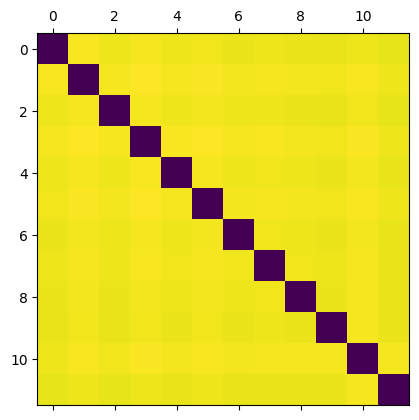

In [78]:
mi_matrix_plot = mi_matrix
# mi_matrix_plot[10,9] = 0
# mi_matrix_plot[9,10] = 0

plt.matshow(mi_matrix_plot)

In [69]:
cosine_similarity(mi_matrix[0,2:], mi_matrix[1,2:])

0.999997011198471

In [79]:
mi_matrix

array([[0.        , 0.09105992, 0.08978032, 0.09088799, 0.08988344,
        0.09025594, 0.08948642, 0.08989628, 0.08941883, 0.08901736,
        0.08986697, 0.08849061],
       [0.09105992, 0.        , 0.09078024, 0.09207352, 0.090915  ,
        0.09143325, 0.09058066, 0.09081265, 0.09037422, 0.08995651,
        0.09103179, 0.08968522],
       [0.08978032, 0.09078024, 0.        , 0.09083198, 0.08980051,
        0.09031911, 0.08966998, 0.08991451, 0.08942605, 0.08907289,
        0.09005042, 0.08865367],
       [0.09088799, 0.09207352, 0.09083198, 0.        , 0.0910881 ,
        0.09173717, 0.09083885, 0.09114086, 0.09062179, 0.09025566,
        0.09147023, 0.08991193],
       [0.08988344, 0.090915  , 0.08980051, 0.0910881 , 0.        ,
        0.09085333, 0.089776  , 0.09021989, 0.08980612, 0.08926779,
        0.09049622, 0.08898763],
       [0.09025594, 0.09143325, 0.09031911, 0.09173717, 0.09085333,
        0.        , 0.09054061, 0.09094696, 0.09055367, 0.08995855,
        0.09116565,

In [80]:
test = prune_images(mi_matrix, 0.99999, 4)

In [81]:
test

[11, 6]